<a href="https://colab.research.google.com/github/jbaremoney/UpsetsPropertiesThresholds/blob/main/new_stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, a few installs and loaders for datasets



In [ ]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.0 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
import torch.autograd as autograd
import math
import medmnist
from medmnist import INFO, Evaluator
from matplotlib import pyplot as plt
from itertools import combinations_with_replacement

In [ ]:
!nvidia-smi

Sat Sep  6 19:29:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [ ]:
def getTrainingDataLoaders(data_set_name, download=True, BATCH_SIZE=128):
    data_flag = data_set_name

    info = INFO[data_flag]
    task = info['task']
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    DataClass = getattr(medmnist, info['python_class'])

    # RGBtransform = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)

    # preprocessing
    if n_channels == 3:
        data_transform = v2.Compose([
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize(mean=[.5], std=[.5])
        ])

    if n_channels == 1:
        data_transform = v2.Compose([
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.RGB(),
            v2.Normalize(mean=[.5], std=[.5])
        ])

    # load the data
    train_dataset = DataClass(split='train', transform=data_transform, download=download)
    test_dataset = DataClass(split='test', transform=data_transform, download=download)

    pil_dataset = DataClass(split='train', download=download)

    # encapsulate data into dataloader form
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
    return info, task, n_classes, train_loader, train_loader_at_eval, test_loader

In [ ]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset, Sampler
from torchvision.transforms import v2
import random
import math

# --- your PaddedMedMNIST as-is ---
TARGET_LENGTH = 14

class PaddedMedMNIST(Dataset):
    def __init__(self, dataset, target_length=TARGET_LENGTH):
        self.dataset = dataset
        self.target_length = target_length

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        label = torch.tensor(label, dtype=torch.float32)
        padded = torch.zeros(self.target_length, dtype=torch.float32)
        padded[:label.numel()] = label
        return img, padded

    def __len__(self):
        return len(self.dataset)


# --- Balanced batch sampler ---
class BalancedBatchSampler(Sampler):
    """
    Yields batches with (approximately) equal counts from each sub-dataset inside a ConcatDataset.

    Args:
        concat_ds: ConcatDataset([...])
        batch_size: total batch size
        strategy: 'upsample' (with replacement so every batch is balanced across entire epoch)
                  or 'min' (stop when any dataset can't fill its share; no replacement)
        drop_last: drop final incomplete batch (recommended True)
        generator: optional torch.Generator for reproducibility
    """
    def __init__(self, concat_ds: ConcatDataset, batch_size: int,
                 strategy: str = "upsample", drop_last: bool = True,
                 generator: torch.Generator | None = None):
        assert isinstance(concat_ds, ConcatDataset), "BalancedBatchSampler requires a ConcatDataset"
        self.concat_ds = concat_ds
        self.batch_size = int(batch_size)
        self.K = len(concat_ds.datasets)
        assert self.K >= 2, "Need at least 2 datasets to balance."
        assert self.batch_size >= self.K, "batch_size must be >= number of datasets"

        # Per-dataset shares sum to batch_size (distribute any remainder to the first few datasets).
        base = self.batch_size // self.K
        extra = self.batch_size % self.K
        self.shares = [base + (1 if i < extra else 0) for i in range(self.K)]

        self.lengths = [len(ds) for ds in concat_ds.datasets]
        self.offsets = []
        running = 0
        for L in self.lengths:
            self.offsets.append(running)
            running += L

        self.strategy = strategy
        self.drop_last = drop_last
        self.gen = generator

        # Precompute how many *balanced* batches we can make without replacement (for 'min').
        self.max_full_batches_min = min(
            (L // s) if s > 0 else 0
            for L, s in zip(self.lengths, self.shares)
        )

        # For 'upsample', define epoch length as number of batches ≈ total_len / batch_size
        total_len = sum(self.lengths)
        self.num_batches_upsample = max(1, total_len // self.batch_size)

    def __len__(self):
        if self.strategy == "min":
            return self.max_full_batches_min
        else:  # 'upsample'
            return self.num_batches_upsample

    def _randperm(self, n):
        if self.gen is None:
            return torch.randperm(n)
        return torch.randperm(n, generator=self.gen)

    def __iter__(self):
        # Build per-dataset index pools (local indices)
        pools = []
        for k, L in enumerate(self.lengths):
            order = self._randperm(L).tolist()
            pools.append(order)

        if self.strategy == "min":
            num_batches = self.max_full_batches_min
            for _ in range(num_batches):
                batch = []
                for k in range(self.K):
                    take = self.shares[k]
                    # pop 'take' elements from the pool (no replacement)
                    chosen_local = pools[k][:take]
                    pools[k] = pools[k][take:]
                    # map to global indices via offset
                    off = self.offsets[k]
                    batch.extend([off + i for i in chosen_local])
                yield batch
            # If not dropping last and any remainder exists (rare with this scheme), we could add a small final batch.
            # But by design with 'min' we usually keep batches uniform and drop incomplete ones.
            if not self.drop_last:
                # Attempt to form one last (possibly smaller) balanced-ish batch
                leftovers = []
                for k in range(self.K):
                    take = min(self.shares[k], len(pools[k]))
                    off = self.offsets[k]
                    leftovers.extend([off + i for i in pools[k][:take]])
                if len(leftovers) > 0:
                    yield leftovers

        else:  # 'upsample' with replacement from small datasets
            num_batches = self.num_batches_upsample
            for _ in range(num_batches):
                batch = []
                for k in range(self.K):
                    take = self.shares[k]
                    off = self.offsets[k]
                    pool = pools[k]
                    if len(pool) < take:
                        # Re-shuffle / top-up this pool
                        pool.extend(self._randperm(self.lengths[k]).tolist())
                    chosen_local = pool[:take]
                    del pool[:take]
                    batch.extend([off + i for i in chosen_local])
                yield batch


# --- Your loader builder, swapped to use the BalancedBatchSampler ---
def get_combined_medmnist_loader(dataset_names, batch_size=128, download=True, train=True,
                                 strategy: str = "upsample", drop_last: bool = True,
                                 num_workers: int = 4, pin_memory: bool = True):
    all_datasets = []

    for name in dataset_names:
        info = INFO[name]
        DataClass = getattr(medmnist, info['python_class'])
        n_channels = info['n_channels']

        if n_channels == 3:
            transform = v2.Compose([
                v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
            ])
        else:
            transform = v2.Compose([
                v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
                v2.RGB(),  # force 3 channels
                v2.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
            ])

        split = 'train' if train else 'test'
        raw_dataset = DataClass(split=split, transform=transform, download=download)
        padded_dataset = PaddedMedMNIST(raw_dataset)
        all_datasets.append(padded_dataset)

    combined_dataset = ConcatDataset(all_datasets)
    batch_sampler = BalancedBatchSampler(
        combined_dataset, batch_size=batch_size, strategy=strategy, drop_last=drop_last
    )

    # IMPORTANT: when using batch_sampler, do not also pass batch_size/shuffle/sampler
    loader = DataLoader(
        combined_dataset,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return loader

Now, on to the good stuff!

In [ ]:
class ClassicNetwork(nn.Module):
    def __init__(self, layer_sizes,bias=True):
        super().__init__()

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            *[z for l in layer_sizes
              for z in [nn.Linear(l[0], l[1],bias=bias), nn.ReLU()]][:-1]
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Set up signed Kaiming initialization.
def signed_kaiming_constant_(tensor, a=0, mode='fan_in', nonlinearity='relu', k=0.5, sparsity=0):

    fan = nn.init._calculate_correct_fan(tensor, mode)  # calculating correct fan, depends on shape and type of nn
    gain = nn.init.calculate_gain(nonlinearity, a)
    std = (gain / math.sqrt(fan))
    # scale by (1/sqrt(k))
    if k != 0:
        std *= (1 / math.sqrt(k))

    with torch.no_grad():
        tensor.uniform_(-std, std)
        if sparsity > 0:
            mask = (torch.rand_like(tensor) > sparsity).float()  # Keeps (1 - sparsity)% weights

            tensor *= mask

        return tensor

# A function to retreive a subset of the top k% of the weights by their score.
# The gradient is estimated by the identity (i.e. it goes "straight-through").
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)

class GetSubnet(autograd.Function):

    @staticmethod
    def forward(ctx, scores, k):

        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1-k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, grad):

        # send the gradient g straight-through on the backward pass.
        return grad, None

# Our maskable replacement for the standard linear layer in torch.
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)
class LinearSubnet(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, k=0.5, init=signed_kaiming_constant_, **kwargs):
        super().__init__(in_features, out_features, bias if isinstance(bias, bool) else True, **kwargs)

        self.k = k
        self.popup_scores = nn.Parameter(torch.randn(out_features, in_features), requires_grad=True)
        self.bias_popup_scores = nn.Parameter(torch.randn(out_features), requires_grad=True)
        self.popup_scores_extra = nn.Parameter(torch.randn(out_features, in_features), requires_grad=True)
        self.bias_popup_scores_extra = nn.Parameter(torch.randn(out_features), requires_grad=True)

        self.initial_popup_scores = self.popup_scores.clone()
        self.initial_bias_popup_scores = self.bias_popup_scores.clone()

        # Initialize weights
        if init == signed_kaiming_constant_:
            init(self.weight, k=k)
        else:
            init(self.weight)

        self.weight.requires_grad_(False)
        if self.bias is not None:
            self.bias.requires_grad_(False)
    def return_to_initial_popup_scores(self):
        self.popup_scores = nn.Parameter(self.initial_popup_scores.clone(),requires_grad=True)
        self.bias_popup_scores = nn.Parameter(self.initial_bias_popup_scores.clone(),requires_grad=True)
        print('Popup Scores Returned to Initial Values')

    def forward(self, x):
        adj = GetSubnet.apply(
            torch.cat((self.popup_scores.abs(),self.popup_scores_extra.abs()),dim=-1), self.k
        )[:, :self.weight.shape[-1]]
        bias_adj = GetSubnet.apply(
            torch.cat((self.bias_popup_scores.abs(),self.bias_popup_scores_extra.abs()), dim=-1), self.k
        )[:self.bias.shape[-1]]

        w = self.weight * adj
        b = self.bias * bias_adj
        return F.linear(x, w, b)


class Network(nn.Module):
    def __init__(self, layer_sizes, k=0.5, init=signed_kaiming_constant_):
        super().__init__()
        self.flatten = nn.Flatten()

        self.layers = nn.ModuleList()
        for i, (in_f, out_f) in enumerate(layer_sizes):
            self.layers.append(LinearSubnet(in_f, out_f,k=k,init=init))
            if i < len(layer_sizes) - 1:
                self.layers.append(nn.ReLU())

    def forward(self, x):
        if x.shape[1:] != (3, 28, 28):
          print(x.shape)
          x.unsqueeze_(0)
          x = x.repeat(3, 1, 1)
        x = self.flatten(x)
        for layer in self.layers:
                x = layer(x)
        return x

In [ ]:
# Define a training function that returns a list of the losses during training.
def trainit(model,
            NUM_EPOCHS,
            train_loader,
            optimizer,
            task,
            n_classes,
            return_losses=False,
            no_progress=False):
  # define loss function
  if task == "multi-label, binary-class":
      criterion = nn.BCEWithLogitsLoss()
  else:
      criterion = nn.CrossEntropyLoss()
  if return_losses:
      losses = []
  # iterate over epochs for training run
  for epoch in range(NUM_EPOCHS):
      model.train()
      if no_progress:
        loader = train_loader
      else:
        loader=tqdm(train_loader)
      for inputs, targets in loader:
          inputs  = inputs.to(device, non_blocking=True)
          targets = targets.to(device, non_blocking=True)
          # forward + backward + optimize
          optimizer.zero_grad()
          outputs = model(inputs)[:,0:n_classes]
          if task == 'multi-label, binary-class':
              targets = targets.to(torch.float32)
              loss = criterion(outputs, targets)
          else:
              targets = targets.squeeze(1)
              loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
          if return_losses:
              losses.append(loss.item())
  if return_losses:
      return losses

# Define an evaluation function
def test(split,
         model,
         train_loader_at_eval,
         test_loader,
         task,
         n_classes,
         data_flag,
         return_metrics=False):
    # define loss function
    if task == "multi-label, binary-class":
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            # inputs  = inputs.to(device, non_blocking=True)
            # targets = targets.to(device, non_blocking=True)
            outputs = model(inputs)[:,0:n_classes]

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze(1)
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        if return_metrics:
          return metrics

Now, let's actually run the dang thing.  Notice, the number of epochs is REALLY high here, since convergence takes a super long time in this case.

Using cuda device


100%|██████████| 560k/560k [00:00<00:00, 655kB/s]
100%|██████████| 5/5 [00:00<00:00, 27.39it/s]


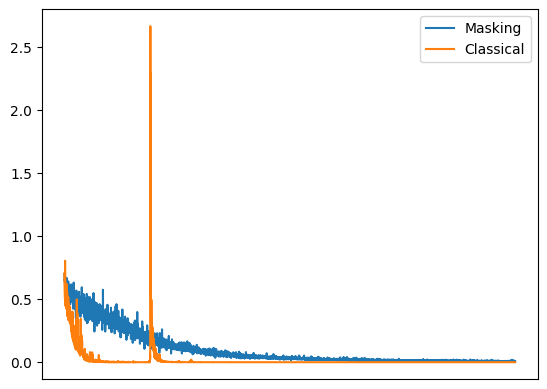

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")
data_set_name = 'breastmnist'
info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)
layer_sizes=[[3*28*28, 256],[256,256],[256, n_classes]]
NUM_EPOCHS = 1000

model = Network(layer_sizes=layer_sizes,k=0.5)
model.to(device)
router_train_score=[]

losses=trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()),task='multi-class',n_classes=14, return_losses=True)
router_train_score.append(losses)

classicmodel = ClassicNetwork(layer_sizes=layer_sizes)
classicmodel.to(device)
classic_train_score=[]
losses=trainit(classicmodel,NUM_EPOCHS,train_loader,optim.Adam(classicmodel.parameters()),task='multi-class',n_classes=14, return_losses=True)
classic_train_score.append(losses)

plt.plot(router_train_score[0], label='Masking')
plt.plot(classic_train_score[0], label='Classical')
plt.legend()
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# plt.yscale('log')


Okay, now on to the fancy stuff.

First off, a recursive router:

In [ ]:
class ClassicNetwork(nn.Module):
    def __init__(self, layer_sizes,bias=True):
        super().__init__()

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            *[z for l in layer_sizes
              for z in [nn.Linear(l[0], l[1],bias=bias), nn.ReLU()]][:-1]
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Set up signed Kaiming initialization.
def signed_kaiming_constant_(tensor, a=0, mode='fan_in', nonlinearity='relu', k=0.5, sparsity=0):

    fan = nn.init._calculate_correct_fan(tensor, mode)  # calculating correct fan, depends on shape and type of nn
    gain = nn.init.calculate_gain(nonlinearity, a)
    std = (gain / math.sqrt(fan))
    # scale by (1/sqrt(k))
    if k != 0:
        std *= (1 / math.sqrt(k))

    with torch.no_grad():
        tensor.uniform_(-std, std)
        if sparsity > 0:
            mask = (torch.rand_like(tensor) > sparsity).float()  # Keeps (1 - sparsity)% weights

            tensor *= mask

        return tensor

# A function to retreive a subset of the top k% of the weights by their score.
# The gradient is estimated by the identity (i.e. it goes "straight-through").
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)

class GetSubnet(autograd.Function):

    @staticmethod
    def forward(ctx, scores, k):

        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1-k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, grad):

        # send the gradient g straight-through on the backward pass.
        return grad, None

# Our maskable replacement for the standard linear layer in torch.
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)
class LinearSubnet(nn.Linear):
    def __init__(self, in_features, out_features, max_recurse_depth=1, router_width=1, bias=True, k=0.5, init=signed_kaiming_constant_, **kwargs):
        super().__init__(in_features, out_features, bias if isinstance(bias, bool) else True, **kwargs)

        self.k = k
        # self.m = m  # number of score choices
        # self.used = {}
        self.recurse_depth = 1
        self.max_recurse_depth = max_recurse_depth
        # Define m sets of pop-up scores
        self.popup_scores = nn.ParameterList([
            nn.Parameter(torch.randn(out_features, in_features)) for _ in range(self.max_recurse_depth)
        ])
        self.bias_popup_scores = nn.ParameterList([
            nn.Parameter(torch.randn(out_features)) for _ in range(self.max_recurse_depth)
        ])
        self.popup_scores_extra = nn.ParameterList([
            nn.Parameter(torch.randn(out_features, in_features)) for _ in range(self.max_recurse_depth)
        ])
        self.bias_popup_scores_extra = nn.ParameterList([
            nn.Parameter(torch.randn(out_features)) for _ in range(self.max_recurse_depth)
        ])

        # Define a router that chooses between m options
        self.router = ClassicNetwork(layer_sizes=[
            [in_features, router_width],
            [router_width, self.max_recurse_depth+1]
        ],bias=False)

        # Initialize weights
        if init == signed_kaiming_constant_:
            init(self.weight, k=k)
        else:
            init(self.weight)

        self.weight.requires_grad_(True)
        if self.bias is not None:
            self.bias.requires_grad_(True)

    def forward(self, x):
        B = x.shape[0]
        device = x.device

        # [B, m]: scores for each of the m pop-up configurations
        router_logits = self.router(x)[:, :-1]
        recurse = (self.router(x)[:,-1]>0)
        selected = torch.argmax(router_logits, dim=-1)  # [B]
        # round=max(k for k in self.used.keys()) + 1 if bool(self.used) else 0
        # self.used[round] = [0 for _ in range(self.m)]
        # for i in range(self.m):
        #   self.used[round][i]+=(selected == i).count_nonzero().item()


        # Create empty masked weights for each sample in batch
        weight = torch.zeros((B, self.out_features, self.in_features), device=device)
        bias = torch.zeros((B, self.out_features), device=device)

        for i in range(self.max_recurse_depth):
            idx = (selected == i).nonzero(as_tuple=True)[0]
            if idx.numel() == 0:
                continue  # skip if no samples selected this mask

            adj = GetSubnet.apply(
                torch.cat((self.popup_scores[i].abs(), self.popup_scores_extra[i].abs()), dim=-1), self.k
            )
            bias_adj = GetSubnet.apply(
                torch.cat((self.bias_popup_scores[i].abs(), self.bias_popup_scores_extra[i].abs()), dim=-1), self.k
            )

            # Generate mask for top-k of the chosen score
            mask = GetSubnet.apply(self.popup_scores[i].abs(), self.k)
            bias_mask = GetSubnet.apply(self.bias_popup_scores[i].abs(), self.k)

            # Apply mask to weights and assign to appropriate batch elements
            weight[idx] = self.weight * adj[:, :self.weight.shape[-1]]
            bias[idx] = self.bias * bias_adj[:self.bias.shape[-1]]

        # Perform batched linear op: [B, out_features] = [B, out, in] @ [B, in, 1]
        out = torch.bmm(weight, x.unsqueeze(-1)).squeeze(-1) + bias
        if not torch.any(recurse) or self.recurse_depth==self.max_recurse_depth:
            return out
        else:
            self.recurse_depth+=1
            recurse = (recurse.squeeze() > 0)
            new_out=self.forward(out)
            updated=out.clone()
            updated[recurse,:]=new_out[recurse,:]
            return updated


class Network(nn.Module):
    def __init__(self, in_size,out_size,hidden_size,max_recurse_depth,router_width, k=0.5, init=signed_kaiming_constant_,):
        super().__init__()
        self.flatten = nn.Flatten()

        self.layers = nn.ModuleList()
        self.layers.append(LinearSubnet(in_size, hidden_size,max_recurse_depth=1, router_width=router_width, k=k,init=init))
        self.layers.append(nn.ReLU())
        self.layers.append(LinearSubnet(hidden_size, hidden_size, max_recurse_depth=max_recurse_depth, router_width=router_width, k=k,init=init))
        self.layers.append(nn.ReLU())
        self.layers.append(LinearSubnet(hidden_size, out_size, max_recurse_depth=1, router_width=router_width, k=k,init=init))
    def forward(self, x):
        if x.shape[1:] != (3, 28, 28):
          print(x.shape)
          x.unsqueeze_(0)
          x = x.repeat(3, 1, 1)
        x = self.flatten(x)
        for layer in self.layers:
                x = layer(x)
        return x

Using cuda device


100%|██████████| 5/5 [00:00<00:00, 26.86it/s]


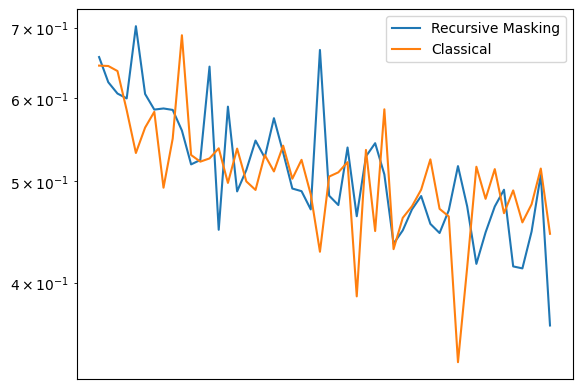

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")
data_set_name = 'breastmnist'
info, task, n_classes, train_loader, train_loader_at_eval, test_loader = getTrainingDataLoaders(data_set_name)
NUM_EPOCHS = 10

model = Network(3*28*28,n_classes,64,10,64,k=0.5)
model.to(device)
router_losses=trainit(model,NUM_EPOCHS,train_loader,optim.Adam(model.parameters()),task=task,n_classes=n_classes, return_losses=True)
classicmodel = ClassicNetwork(layer_sizes=[[3*28*28,32],[32,32],[32,n_classes]])
classicmodel.to(device)

classic_losses=trainit(classicmodel,NUM_EPOCHS,train_loader,optim.Adam(classicmodel.parameters()),task='multi-class',n_classes=n_classes, return_losses=True)

plt.plot(router_losses, label='Recursive Masking')
plt.plot(classic_losses, label='Classical')
plt.legend()
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.yscale('log')

Now, some routers to predict scores.  First up is the "implicit" router that full on guesses the score and is trained as part of the model.

In [ ]:
class ClassicNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            *[z for l in layer_sizes
              for z in [nn.Linear(l[0], l[1]), nn.ReLU()]][:-1]
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Set up signed Kaiming initialization.
def signed_kaiming_constant_(tensor, a=0, mode='fan_in', nonlinearity='relu', k=0.5, sparsity=0):

    fan = nn.init._calculate_correct_fan(tensor, mode)  # calculating correct fan, depends on shape and type of nn
    gain = nn.init.calculate_gain(nonlinearity, a)
    std = (gain / math.sqrt(fan))
    # scale by (1/sqrt(k))
    if k != 0:
        std *= (1 / math.sqrt(k))

    with torch.no_grad():
        tensor.uniform_(-std, std)
        if sparsity > 0:
            mask = (torch.rand_like(tensor) > sparsity).float()  # Keeps (1 - sparsity)% weights

            tensor *= mask

        return tensor

# A function to retreive a subset of the top k% of the weights by their score.
# The gradient is estimated by the identity (i.e. it goes "straight-through").
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # scores: shape (..., N) or (..., out, in). We operate over the last dimension(s) flattened per-sample
        orig_shape = scores.shape
        B = scores.shape[0] if scores.dim() > 1 else 1
        per_sample_numel = int(scores[0].numel()) if B > 1 else scores.numel()

        # Flatten each sample to 1-D, run top-k mask per sample
        s = scores.reshape(B, -1).clone()
        out = s.clone()
        # sort ascending per row
        idx = torch.argsort(s, dim=-1)             # [B, M]
        j = int((1 - k) * s.shape[-1])             # number to zero per sample
        flat_out = out

        # zero the smallest (1-k)% per sample
        rows = torch.arange(B, device=scores.device).unsqueeze(-1)
        flat_out[rows, idx[:, :j]] = 0
        flat_out[rows, idx[:, j:]] = 1

        return flat_out.reshape(orig_shape)

    @staticmethod
    def backward(ctx, grad):
        # straight-through estimator
        return grad, None


class LinearSubnet(nn.Linear):
    def __init__(self, in_features, out_features, router=None,
                 bias=True, k=0.5, init=signed_kaiming_constant_, **kwargs):
        super().__init__(in_features, out_features, bias if isinstance(bias, bool) else True, **kwargs)
        self.k = float(k)
        self.router = router
        self.out_features = out_features
        self.in_features = in_features

        if router is None:
            # unrouted: keep the double-score params as before
            self.popup_scores = nn.Parameter(torch.randn(*self.weight.shape))
            self.popup_scores_extra = nn.Parameter(torch.randn(*self.weight.shape))
            self.bias_popup_scores = nn.Parameter(torch.randn(*self.bias.shape))
            self.bias_popup_scores_extra = nn.Parameter(torch.randn(*self.bias.shape))
        # else: router produces scores; we don't keep per-layer score params

        # init and freeze base weights
        if init == signed_kaiming_constant_:
            init(self.weight, k=self.k)
        else:
            init(self.weight)
        self.weight.requires_grad_(False)
        if self.bias is not None:
            self.bias.requires_grad_(False)

    def forward(self, x, context):
        if self.router is not None:
            B = x.shape[0]
            out_f, in_f = self.out_features, self.in_features

            # Router must output: out*(2*in) + (2*out)
            router_out = self.router(context)  # [B, out*(2*in) + 2*out]
            w_scores_flat = router_out[:, : out_f * (2 * in_f)]
            b_scores_flat = router_out[:, out_f * (2 * in_f) : ]

            # reshape and abs just like unrouted
            w_scores = w_scores_flat.reshape(B, out_f, 2 * in_f).abs()  # [B, out, 2*in]
            b_scores = b_scores_flat.reshape(B, 2 * out_f).abs()        # [B, 2*out]

            # top-k over doubled scores, then slice first half
            w_mask_2x = GetSubnet.apply(w_scores, self.k)               # [B, out, 2*in] in {0,1}
            b_mask_2x = GetSubnet.apply(b_scores, self.k)               # [B, 2*out]     in {0,1}
            w_mask = w_mask_2x[:, :, :in_f]                             # [B, out, in]
            b_mask = b_mask_2x[:, :out_f]                               # [B, out]

            # masked linear
            W_eff = self.weight.unsqueeze(0) * w_mask                   # [B, out, in]
            b_eff = self.bias.unsqueeze(0) * b_mask                     # [B, out]
            y = torch.bmm(W_eff, x.unsqueeze(-1)).squeeze(-1) + b_eff
            return y

        else:
            # unrouted path (unchanged)
            adj = GetSubnet.apply(
                torch.cat((self.popup_scores.abs(), self.popup_scores_extra.abs()), dim=-1), self.k
            )[:, : self.weight.shape[-1]]
            bias_adj = GetSubnet.apply(
                torch.cat((self.bias_popup_scores.abs(), self.bias_popup_scores_extra.abs()), dim=-1), self.k
            )[: self.bias.shape[-1]]

            w = self.weight * adj
            b = self.bias * bias_adj
            return F.linear(x, w, b)


class Network(nn.Module):
    def __init__(self, layer_sizes, routers=None, k=0.5, init=signed_kaiming_constant_):
        super().__init__()

        self.flatten = nn.Flatten()

        self.layers = nn.ModuleList()
        if routers is not None:
          for i, (in_f, out_f) in enumerate(layer_sizes):
              self.layers.append(LinearSubnet(in_f, out_f, routers[i], k=k, init=init))
              if i < len(layer_sizes) - 1:
                  self.layers.append(nn.ReLU())
        else:
          for i, (in_f, out_f) in enumerate(layer_sizes):
            self.layers.append(LinearSubnet(in_f, out_f, k=k, init=init))
            if i < len(layer_sizes) - 1:
                self.layers.append(nn.ReLU())

    def forward(self, x, context=None):
        x = self.flatten(x)
        for layer in self.layers:
            if isinstance(layer, LinearSubnet):
                x = layer(x, context)
            else:
                x = layer(x)
        return x

In [ ]:
import time

def testlosses(model, test_data, test_func, context=None):
  # define loss function
  criterion = nn.MSELoss()
  model.eval()
  outputs = model(test_data, context.expand(test_data.shape[0], -1)) if context is not None else model(test_data)
  targets = test_func(test_data)
  loss = criterion(outputs, targets)
  return loss.item()
def trainloop(model,
          optimizer,
          test_data,
          test_func,
          NUM_EPOCHS,
          return_training_losses=False,
          return_test_losses=True,
          context=None):
  xs=[]
  ys=[]
  start = time.time()
  # define loss function
  criterion = nn.MSELoss()
  if return_training_losses:
      losses = []
  model.train()
  for i in range(1,NUM_EPOCHS+1):
    for _ in range(100):
      end = time.time()
      length = end - start
      if xs==[]:
          xs.append(length)
          start = time.time()
          ys.append(testlosses(model, test_data, test_func, context=context))
      elif length-xs[-1] > 1:
        xs.append(xs[-1]+length)
        start = time.time()
        ys.append(testlosses(model, test_data, test_func, context=context))
      inputs=torch.rand(16,1)
      inputs.requires_grad_(True)
      # forward + backward + optimize
      optimizer.zero_grad()
      outputs = model(inputs, context.expand(inputs.shape[0], -1)) if context is not None else model(inputs)
      targets = test_func(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      if return_training_losses:
          losses.append(loss.item())
  if return_training_losses:
    return losses
  if return_test_losses:
    return xs,ys

def get_poly(coeffs):
  def poly(x):
    result = torch.zeros_like(x)
    for i, a in enumerate(coeffs):
        result += a * x**i
    return result
  return poly

num_polys_to_test = 100

plots={'Classical':{k:{} for k in range(num_polys_to_test)},'Masking':{k:{} for k in range(num_polys_to_test)}}
context={}
test_data={}
test_func={}
for k in range(num_polys_to_test):
  test_data[k]=torch.rand(1000,1)
  coeffs = torch.rand(torch.randint(low=1, high=5, size=(1,)).item(),1)
  test_func[k] = get_poly(coeffs)

  context_dat = torch.rand(10,1)
  context[k] = torch.cat((context_dat, test_func[k](context_dat)), dim=0).view(1, -1)

n_low=5
n_high=5
d_low=1
d_high=1

n_low_masking=5
n_high_masking=5
d_low_masking=1
d_high_masking=1

NUM_EPOCHS = 5

print('=================')
print('No Masking Test')
print('=================')
for n in range(n_low,n_high+1):
  for d in range(d_low,d_high+1):
    w=2**n
    layer_sizes=[[1, w]]
    for _ in range(d):
      layer_sizes.append([w,w])
    layer_sizes.append([w,1])
    classic_model = ClassicNetwork(layer_sizes)
    for k in range(num_polys_to_test):
      print('  Round '+str(k))
      optimizer = optim.Adam(classic_model.parameters())
      print(f"    Width: {w} (2**{n}), Depth: {d}")
      print('    =================')
      xs,ys = trainloop(classic_model, optimizer, test_data[k], test_func[k], NUM_EPOCHS, return_training_losses=False, return_test_losses=True)
      plots['Classical'][k][(w,d)]=(xs,ys)
print('=================')
print('Masking Tests')
print('=================')
for n in range(n_low_masking,n_high_masking+1):
  for d in range(d_low_masking,d_high_masking+1):
    w=2**n
    layer_sizes=[[1, w]]
    for _ in range(d):
      layer_sizes.append([w,w])
    layer_sizes.append([w,1])
    context_size=20
    routers = [
        ClassicNetwork(layer_sizes=[
            [context_size, 32],
            [32, 32],
            [32, l[1] * l[0] + l[1]]]
        ) for l in layer_sizes
    ]
    model = Network(layer_sizes, routers=routers, k=0.5)
    for k in range(num_polys_to_test):
      print('  Round '+str(k))
      optimizer = optim.Adam(model.parameters())
      print(f"    Width: {w} (2**{n}), Depth: {d}")
      print('    =================')
      xs,ys = trainloop(model, optimizer, test_data[k], test_func[k], NUM_EPOCHS, return_training_losses=False, return_test_losses=True, context=context[k])
      plots['Masking'][k][(w,d)]=(xs,ys)

No Masking Test
  Round 0
    Width: 32 (2**5), Depth: 1
  Round 1
    Width: 32 (2**5), Depth: 1
  Round 2
    Width: 32 (2**5), Depth: 1
  Round 3
    Width: 32 (2**5), Depth: 1
  Round 4
    Width: 32 (2**5), Depth: 1
  Round 5
    Width: 32 (2**5), Depth: 1
  Round 6
    Width: 32 (2**5), Depth: 1
  Round 7
    Width: 32 (2**5), Depth: 1
  Round 8
    Width: 32 (2**5), Depth: 1
  Round 9
    Width: 32 (2**5), Depth: 1
  Round 10
    Width: 32 (2**5), Depth: 1
  Round 11
    Width: 32 (2**5), Depth: 1
  Round 12
    Width: 32 (2**5), Depth: 1
  Round 13
    Width: 32 (2**5), Depth: 1
  Round 14
    Width: 32 (2**5), Depth: 1
  Round 15
    Width: 32 (2**5), Depth: 1
  Round 16
    Width: 32 (2**5), Depth: 1
  Round 17
    Width: 32 (2**5), Depth: 1
  Round 18
    Width: 32 (2**5), Depth: 1
  Round 19
    Width: 32 (2**5), Depth: 1
  Round 20
    Width: 32 (2**5), Depth: 1
  Round 21
    Width: 32 (2**5), Depth: 1
  Round 22
    Width: 32 (2**5), Depth: 1
  Round 23
    Width: 32 (2*

RuntimeError: shape '[1000, 64]' is invalid for input of size 0

In [ ]:
for run_type in plots.keys():
    for (w,d) in plots[run_type][0].keys():
      daty=[plots[run_type][k][(w,d)][-1][-1] for k in sorted(plots[run_type].keys())]
      if run_type=='Classical':
        line='-'
      else:
        line='--'
      plt.plot([k for k in sorted(plots[run_type].keys())],daty, label=run_type+' (Width: '+str(w)+', Depth: '+str(d)+')', linestyle=line)

# Plot the test loss for the model
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Test Loss')
plt.show()

Now, an "explicit" router that is trained separately from the rest of the network.  We build a dataset of masks and teach it to guess outputs that the decode head of an autoencoder turns into scores.

In [ ]:
class MaskAE(nn.Module):
    """Small MLP autoencoder for flattened doubled masks of length D."""
    def __init__(self, D, embed_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(D, max(128, embed_dim*2)),
            nn.ReLU(),
            nn.Linear(max(128, embed_dim*2), embed_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, max(128, embed_dim*2)),
            nn.ReLU(),
            nn.Linear(max(128, embed_dim*2), D)   # raw logits for masks
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

    def encode(self, x):  # x: [B, D]
        return self.encoder(x)

    def decode(self, z):  # z: [B, E]
        return self.decoder(z)

class MasksOnlyDataset(Dataset):
    def __init__(self, targets):  # targets: [N, D] of {0,1}
        self.targets = targets
    def __len__(self): return self.targets.size(0)
    def __getitem__(self, i):
        t = self.targets[i]
        return t, t  # (input=mask, target=mask)

def train_autoencoder_on_masks(targets,
                               D,            # flattened doubled length = out_f*(2*in_f) + 2*out_f
                               in_f, out_f,  # layer shape
                               k,            # keep ratio used by GetSubnet
                               embed_dim=64,
                               epochs=20,
                               batch=256,
                               lr=1e-3,
                               device='cpu',
                               aux_logit_loss_weight=0.0):
    """
    targets: [N, D] binary doubled masks (weight: [out, 2*in], bias: [2*out], flattened)
    Trains AE so that decoder(pred_z) -> logits -> GetSubnet(k) matches targets.
    Optionally adds a tiny auxiliary loss on logits (post-sigmoid) for stability.
    """
    ds = MasksOnlyDataset(targets)  # (mask, mask)
    loader = DataLoader(ds, batch_size=batch, shuffle=True)

    ae = MaskAE(D, embed_dim).to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=lr)

    D_w = out_f * (2 * in_f)
    D_b = 2 * out_f

    ae.train()
    for _ in range(epochs):
        for m_in, m_tgt in loader:
            m_in, m_tgt = m_in.to(device), m_tgt.to(device)  # [B, D], {0,1}

            logits = ae(m_in)  # [B, D]

            # Split & reshape to doubled shapes, mirror router path
            w_logits = logits[:, :D_w].reshape(-1, out_f, 2*in_f).abs()
            b_logits = logits[:, D_w:].reshape(-1, 2*out_f).abs()

            # STE top-k to binarize
            w_mask_hat = GetSubnet.apply(w_logits, k)    # [B, out, 2*in] in {0,1}
            b_mask_hat = GetSubnet.apply(b_logits, k)    # [B, 2*out]   in {0,1}

            pred_mask = torch.cat([w_mask_hat.reshape(logits.size(0), -1),
                                   b_mask_hat.reshape(logits.size(0), -1)], dim=1)  # [B, D]

            # Primary loss: match binary masks after GetSubnet
            loss = F.mse_loss(pred_mask, m_tgt)

            # Optional tiny auxiliary term (can help stabilize training a bit)
            if aux_logit_loss_weight > 0.0:
                loss = loss + aux_logit_loss_weight * F.mse_loss(torch.sigmoid(logits), m_tgt)

            opt.zero_grad()
            loss.backward()
            opt.step()

    # freeze decoder head
    for p in ae.decoder.parameters():
        p.requires_grad = False
    ae.eval()
    return ae, ae.decoder

def train_autoencoders_for_all_layers(datasets_per_layer,
                                      layer_sizes,
                                      embed_dims,
                                      k=0.5,
                                      epochs=20,
                                      batch=256,
                                      lr=1e-3,
                                      device='cpu',
                                      aux_logit_loss_weight=0.0):
    """
    Returns: (decoders_frozen, full_AEs)
    Each dataset[i].targets is [N, D_i] with doubled masks.
    """
    if isinstance(embed_dims, int):
        embed_dims = [embed_dims] * len(layer_sizes)

    decoders, aes = [], []
    for (in_f, out_f), ds, E in zip(layer_sizes, datasets_per_layer, embed_dims):
        D = out_f * (2 * in_f) + 2 * out_f
        all_masks = ds.targets.to(device)  # [N, D], {0,1}

        ae, decoder = train_autoencoder_on_masks(
            targets=all_masks,
            D=D,
            in_f=in_f,
            out_f=out_f,
            k=k,
            embed_dim=E,
            epochs=epochs,
            batch=batch,
            lr=lr,
            device=device,
            aux_logit_loss_weight=aux_logit_loss_weight
        )
        decoders.append(decoder)  # frozen
        aes.append(ae)

    return decoders, aes

In [ ]:
class ClassicNetwork(nn.Module):
    def __init__(self, layer_sizes, expect_context=False, context_dim=0):
        super().__init__()
        self.flatten = nn.Flatten()
        if expect_context:
            # add context_dim to first layer's input width
            in0, out0 = layer_sizes[0]
            layer_sizes = [[in0 + context_dim, out0]] + layer_sizes[1:]

        self.linear_relu_stack = nn.Sequential(
            *[z for l in layer_sizes
              for z in [nn.Linear(l[0], l[1]), nn.ReLU()]][:-1]
        )

    def forward(self, x, context=None):
        x = self.flatten(x)
        if context is not None:
            # broadcast [1, C] or accept [N, C]
            if context.dim() == 2 and context.size(0) == 1:
                context = context.expand(x.size(0), -1)
            elif context.size(0) != x.size(0):
                raise ValueError(f"context batch {context.size(0)} must be 1 or match x batch {x.size(0)}")
            x = torch.cat([x, context], dim=1)
        return self.linear_relu_stack(x)

# Set up signed Kaiming initialization.
def signed_kaiming_constant_(tensor, a=0, mode='fan_in', nonlinearity='relu', k=0.5, sparsity=0):

    fan = nn.init._calculate_correct_fan(tensor, mode)  # calculating correct fan, depends on shape and type of nn
    gain = nn.init.calculate_gain(nonlinearity, a)
    std = (gain / math.sqrt(fan))
    # scale by (1/sqrt(k))
    if k != 0:
        std *= (1 / math.sqrt(k))

    with torch.no_grad():
        tensor.uniform_(-std, std)
        if sparsity > 0:
            mask = (torch.rand_like(tensor) > sparsity).float()  # Keeps (1 - sparsity)% weights

            tensor *= mask

        return tensor

# A function to retreive a subset of the top k% of the weights by their score.
# The gradient is estimated by the identity (i.e. it goes "straight-through").
# See the paper "What's Hidden in a Randomly Weighted Neural Network?" for
# more details (https://arxiv.org/abs/1911.13299)
# (this code adapted from https://github.com/iceychris/edge-popup)

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # scores: shape (..., N) or (..., out, in). We operate over the last dimension(s) flattened per-sample
        orig_shape = scores.shape
        B = scores.shape[0] if scores.dim() > 1 else 1
        per_sample_numel = int(scores[0].numel()) if B > 1 else scores.numel()

        # Flatten each sample to 1-D, run top-k mask per sample
        s = scores.reshape(B, -1).clone()
        out = s.clone()
        # sort ascending per row
        idx = torch.argsort(s, dim=-1)             # [B, M]
        j = int((1 - k) * s.shape[-1])             # number to zero per sample
        flat_out = out

        # zero the smallest (1-k)% per sample
        rows = torch.arange(B, device=scores.device).unsqueeze(-1)
        flat_out[rows, idx[:, :j]] = 0
        flat_out[rows, idx[:, j:]] = 1

        return flat_out.reshape(orig_shape)

    @staticmethod
    def backward(ctx, grad):
        # straight-through estimator
        return grad, None


class LinearSubnet(nn.Linear):
    def __init__(self, in_features, out_features, router=None, decoder=None,
                 bias=True, k=0.5, init=signed_kaiming_constant_, **kwargs):
        super().__init__(in_features, out_features, bias if isinstance(bias, bool) else True, **kwargs)
        self.k = float(k)
        self.router = router
        self.decoder = decoder  # frozen module mapping embedding -> mask logits

        if router is None:
            # unrouted: keep double-score params
            self.popup_scores = nn.Parameter(torch.randn(*self.weight.shape))
            self.popup_scores_extra = nn.Parameter(torch.randn(*self.weight.shape))
            self.bias_popup_scores = nn.Parameter(torch.randn(*self.bias.shape))
            self.bias_popup_scores_extra = nn.Parameter(torch.randn(*self.bias.shape))

        if init == signed_kaiming_constant_:
            init(self.weight, k=self.k)
        else:
            init(self.weight)
        self.weight.requires_grad_(False)
        if self.bias is not None:
            self.bias.requires_grad_(False)

    def forward(self, x, context):
        if self.router is not None:
            B = x.shape[0]
            out_f, in_f = self.out_features, self.in_features
            D_w = out_f*(2*in_f)

            z = self.router(context)           # [B, E]
            logits = self.decoder(z)           # [B, D_w + 2*out_f]

            w_logits = logits[:, :D_w].reshape(B, out_f, 2*in_f).abs()
            b_logits = logits[:, D_w:].reshape(B, 2*out_f).abs()

            w_mask_2x = GetSubnet.apply(w_logits, self.k)
            b_mask_2x = GetSubnet.apply(b_logits, self.k)

            w_mask = w_mask_2x[:, :, :in_f]   # slice like unrouted trick
            b_mask = b_mask_2x[:, :out_f]

            W_eff = self.weight.unsqueeze(0) * w_mask
            b_eff = self.bias.unsqueeze(0) * b_mask
            y = torch.bmm(W_eff, x.unsqueeze(-1)).squeeze(-1) + b_eff
            return y

        # unrouted branch (unchanged)
        adj = GetSubnet.apply(
            torch.cat((self.popup_scores.abs(), self.popup_scores_extra.abs()), dim=-1), self.k
        )[:, : self.weight.shape[-1]]
        bias_adj = GetSubnet.apply(
            torch.cat((self.bias_popup_scores.abs(), self.bias_popup_scores_extra.abs()), dim=-1), self.k
        )[: self.bias.shape[-1]]
        return F.linear(x, self.weight * adj, self.bias * bias_adj)


class Network(nn.Module):
    def __init__(self, layer_sizes, routers=None, k=0.5, init=signed_kaiming_constant_):
        super().__init__()

        self.flatten = nn.Flatten()

        self.layers = nn.ModuleList()
        if routers is not None:
          for i, (in_f, out_f) in enumerate(layer_sizes):
              self.layers.append(LinearSubnet(in_f, out_f, routers[i], k=k, init=init))
              if i < len(layer_sizes) - 1:
                  self.layers.append(nn.ReLU())
        else:
          for i, (in_f, out_f) in enumerate(layer_sizes):
            self.layers.append(LinearSubnet(in_f, out_f, k=k, init=init))
            if i < len(layer_sizes) - 1:
                self.layers.append(nn.ReLU())

    def forward(self, x, context=None):
        x = self.flatten(x)
        for layer in self.layers:
            if isinstance(layer, LinearSubnet):
                x = layer(x, context)
            else:
                x = layer(x)
        return x

In [ ]:
def _flatten_X(X: torch.Tensor) -> torch.Tensor:
    """Flatten any X to [N, in_dim]."""
    if X.dim() == 2:
        return X
    return X.reshape(X.size(0), -1)

def _process_Y_to_2d(Y: torch.Tensor, num_classes: int | None = None) -> torch.Tensor:
    """
    Make Y shape [N, out_dim] in float:
      - If long/int and 1D: one-hot to [N, num_classes]
      - Else: flatten to [N, -1] and cast float
    """
    if Y.dtype in (torch.int8, torch.int16, torch.int32, torch.int64) and Y.dim() == 1:
        if num_classes is None:
            num_classes = int(Y.max().item()) + 1
        oh = torch.zeros(Y.size(0), num_classes, dtype=torch.float32, device=Y.device)
        oh.scatter_(1, Y.view(-1, 1), 1.0)
        return oh
    # regression or already vector: flatten to 2D and cast
    if Y.dim() == 1:
        Y = Y.unsqueeze(1)
    elif Y.dim() > 2:
        Y = Y.reshape(Y.size(0), -1)
    return Y.to(torch.float32)

@torch.no_grad()
def build_contexts_from_function(
    test_func,
    num_contexts: int = 100,
    points_per_context: int = 10,
    in_dim: int = 1,          # <- NEW: input dimensionality
    device: str = "cpu",
):
    """
    Build a [num_contexts, points_per_context*(in_dim + out_dim)] context tensor by:
      1) sampling X ~ U(0,1) with shape [num_contexts, points, in_dim]
      2) Y = test_func(X_flat).view(num_contexts, points, out_dim)
      3) per-row context = concat([X, Y], dim=-1) then flatten to [num_contexts, C]
    Works for arbitrary in_dim and whatever out_dim test_func returns.
    """
    # [N, P, in_dim]
    X = torch.rand(num_contexts, points_per_context, in_dim, device=device)

    # flatten to [N*P, in_dim] → run func → [N*P, out_dim]
    X_flat = X.reshape(-1, in_dim)
    Y_flat = test_func(X_flat)                       # [N*P, out_dim]
    out_dim = Y_flat.shape[-1]
    Y = Y_flat.reshape(num_contexts, points_per_context, out_dim)

    # [N, P, in_dim+out_dim] → [N, P*(in_dim+out_dim)]
    ctx = torch.cat([X, Y], dim=-1).reshape(num_contexts, -1)
    return ctx  # [num_contexts, points*(in_dim+out_dim)]

@torch.no_grad()
def build_contexts_from_training(
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    num_contexts: int = 100,
    points_per_context: int = 10,
    device: str = "cpu",
    replace: bool = True,
    num_classes: int | None = None,   # <- NEW
):
    """
    Build contexts from training data, shape-agnostic.
    X_train: [N, ...]  (images OK)
    Y_train: [N] (class ids) or [N, ...] (regression/one-hot/etc.)

    Returns: [num_contexts, points*(in_dim + out_dim)]
    """
    # Flatten/normalize on CPU for memory friendliness
    Xf = _flatten_X(X_train.detach().to("cpu"))
    Yf = _process_Y_to_2d(Y_train.detach().to("cpu"), num_classes=num_classes)

    N = Xf.size(0)
    in_dim  = Xf.size(1)
    out_dim = Yf.size(1)

    if replace:
        idx = torch.randint(low=0, high=N, size=(num_contexts, points_per_context))
    else:
        if points_per_context > N:
            raise ValueError("points_per_context cannot exceed dataset size when replace=False")
        idx = torch.stack([torch.randperm(N)[:points_per_context] for _ in range(num_contexts)], dim=0)

    Xs = Xf[idx]  # [num_contexts, points, in_dim]
    Ys = Yf[idx]  # [num_contexts, points, out_dim]

    ctx = torch.cat([Xs, Ys], dim=-1).reshape(num_contexts, -1)  # [num_contexts, points*(in_dim+out_dim)]
    return ctx.to(device)


@torch.no_grad()
def build_single_context_from_training(
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    points_per_context: int = 10,
    device: str = "cpu",
    replace: bool = True,
    num_classes: int | None = None,   # <- NEW
):
    return build_contexts_from_training(
        X_train, Y_train,
        num_contexts=1,
        points_per_context=points_per_context,
        device=device,
        replace=replace,
        num_classes=num_classes,
    )

# ---- Utilities to flatten/unflatten layer masks (shape-agnostic) ----
def flatten_layer_masks(w_mask: torch.Tensor, b_mask: torch.Tensor):
    """
    Accepts:
      w_mask: [..., out, in]   (or doubled [..., out, 2*in] — caller decides)
      b_mask: [..., out]       (or doubled [..., 2*out])
    Returns flattened 1D vector of both, concatenated along last dim.
    """
    return torch.cat([w_mask.reshape(-1), b_mask.reshape(-1)], dim=0)


def layer_output_size(in_f: int, out_f: int, doubled: bool = False) -> int:
    """
    Returns flattened mask size for a layer, respecting doubled scheme if requested.
    """
    if doubled:
        return out_f * (2 * in_f) + 2 * out_f
    else:
        return out_f * in_f + out_f

# ---- Extract masks from scores-only model (no grad), agnostic to sizes ----
@torch.no_grad()
def extract_masks_from_scores_model(model, k: float, doubled: bool = True):
    """
    Returns list of flattened target vectors per LinearSubnet layer.
    If doubled=True, we concatenate popup_scores and *_extra along 'in' (and bias),
    matching the doubled scheme used by your router/decoder.
    """
    targets_per_layer = []
    for layer in model.layers:
        if isinstance(layer, LinearSubnet) and layer.router is None:
            if doubled:
                adj = torch.cat((layer.popup_scores.abs(),
                                 layer.popup_scores_extra.abs()), dim=-1).detach()
                bias_adj = torch.cat((layer.bias_popup_scores.abs(),
                                      layer.bias_popup_scores_extra.abs()), dim=-1).detach()
            else:
                adj = layer.popup_scores.abs().detach()
                bias_adj = layer.bias_popup_scores.abs().detach()

            targets_per_layer.append(flatten_layer_masks(adj, bias_adj))
    return targets_per_layer  # list of 1D tensors

class RouterLayerDataset(Dataset):
    """Holds (context -> target_mask_flat) pairs for ONE layer."""
    def __init__(self, contexts: torch.Tensor, targets: torch.Tensor):  # [N, C], [N, D]
        self.contexts = contexts
        self.targets = targets

    def __len__(self):
        return self.contexts.size(0)

    def __getitem__(self, idx):
        return self.contexts[idx], self.targets[idx]


def build_router_for_layer(context_size, embed_dim, hidden=32):
    return ClassicNetwork(layer_sizes=[
        [context_size, hidden],
        [hidden, hidden],
        [hidden, embed_dim],
    ])

def train_router_with_decoder(router, decoder, dataset, in_f, out_f, k, epochs=10, batch_size=64, lr=1e-3, device='cpu'):
    """
    router(ctx) -> z  (embedding)
    decoder(z)  -> mask logits of length D = out_f*(2*in_f) + 2*out_f
    STE top-k -> binary masks; loss vs target binary masks (dataset.targets).
    """
    router.to(device)
    decoder.to(device)
    for p in decoder.parameters():
        p.requires_grad = False

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(router.parameters(), lr=lr)

    D_w = out_f * (2 * in_f)
    D_b = 2 * out_f

    router.train()
    for _ in range(epochs):
        for ctx, tgt in loader:
            ctx = ctx.to(device)
            tgt = tgt.to(device)  # [B, D] in {0,1}

            z = router(ctx)           # [B, E]
            logits = decoder(z)       # [B, D]

            w_logits = logits[:, :D_w].reshape(-1, out_f, 2 * in_f).abs()
            b_logits = logits[:, D_w:].reshape(-1, 2 * out_f).abs()

            w_mask_hat = GetSubnet.apply(w_logits, k)  # [B, out, 2*in]
            b_mask_hat = GetSubnet.apply(b_logits, k)  # [B, 2*out]

            pred = torch.cat([w_mask_hat.reshape(logits.size(0), -1),
                              b_mask_hat.reshape(logits.size(0), -1)], dim=1)  # [B, D]

            # BCE on {0,1} masks (pred is {0,1} due to STE; BCE or MSE both fine)
            loss = F.binary_cross_entropy(pred, tgt)

            opt.zero_grad()
            loss.backward()
            opt.step()

    return router

def fit_scores_and_collect_targets(layer_sizes,
                                   base_snaps,
                                   k,
                                   x_train,          # tensor [N, in_dim]
                                   f_train,          # callable: x -> y
                                   epochs_scores=5,
                                   batch_size=128,
                                   device='cpu'):
    # Build scores-only model and APPLY the shared base weights
    scores_model = Network(layer_sizes, routers=None, k=k).to(device)
    apply_base_weights(scores_model, base_snaps)

    # Optimizer: only score params (weights are frozen in LinearSubnet)
    params = []
    for lyr in scores_model.layers:
        if isinstance(lyr, LinearSubnet) and lyr.router is None:
            params.extend([lyr.popup_scores, lyr.popup_scores_extra,
                           lyr.bias_popup_scores, lyr.bias_popup_scores_extra])
    opt = torch.optim.Adam(params)

    # Prepare (x, y) tensors
    x_train = x_train.to(device)
    with torch.no_grad():
        y_train = f_train(x_train)  # same device as x

    # Train scores on this task using the new trainloop signature
    _ = trainloop(scores_model, opt,
                  x_train=x_train,
                  y_train=y_train,
                  NUM_EPOCHS=epochs_scores,
                  batch_size=batch_size,
                  x_val=None, y_val=None,
                  return_training_losses=False,
                  return_val_curve=False,
                  context=None,   # scores model ignores context
                  shuffle=True)

    # Extract binary *doubled* masks as supervision targets (unchanged)
    targets_per_layer = extract_masks_from_scores_model(scores_model, k)

    # (Optional) re-randomize score params so each task starts fresh
    for lyr in scores_model.layers:
        if isinstance(lyr, LinearSubnet) and lyr.router is None:
            dev = next(scores_model.parameters()).device
            lyr.popup_scores         = nn.Parameter(torch.randn(*lyr.weight.shape, device=dev))
            lyr.popup_scores_extra   = nn.Parameter(torch.randn(*lyr.weight.shape, device=dev))
            lyr.bias_popup_scores    = nn.Parameter(torch.randn(*lyr.bias.shape,   device=dev))
            lyr.bias_popup_scores_extra = nn.Parameter(torch.randn(*lyr.bias.shape, device=dev))

    return targets_per_layer

@torch.no_grad()
def build_contexts_from_loader_with_model(
    dataloader,
    model,                      # scores-only model with masks installed
    num_contexts: int,
    points_per_context: int,
    in_dim: int,
    device: str = "cpu",
    forward_bs: int = 4096,     # chunked forward to avoid OOM
) -> torch.Tensor:
    """
    Use ONLY the dataloader's INPUTS as the x-source for contexts.
    Targets from the loader are IGNORED.
    We compute y = model(x) to complete the context rows [x;y] per point.
    Returns: [num_contexts, points_per_context*(in_dim + out_dim)] on `device`.
    """
    needed = num_contexts * points_per_context

    # 1) Gather enough inputs from the loader (on CPU for memory friendliness)
    X_pool = []
    tot = 0
    for xb, *_rest in dataloader:
        X_pool.append(xb.detach().cpu())
        tot += xb.size(0)
        if tot >= needed:
            break
    if not X_pool:
        raise RuntimeError("DataLoader yielded no batches; cannot build contexts.")
    X_pool = torch.cat(X_pool, dim=0)        # [M, ...]
    X_pool = _flatten_X(X_pool)              # [M, in_dim]
    M = X_pool.size(0)

    # 2) Forward through the masked model in chunks to get Y_pool
    Y_pool_list = []
    for start in range(0, M, forward_bs):
        end = min(start + forward_bs, M)
        x_chunk = X_pool[start:end].to(device)
        y_chunk = model(x_chunk)             # [B, out_dim]
        Y_pool_list.append(y_chunk.detach().cpu())
    Y_pool = torch.cat(Y_pool_list, dim=0)   # [M, out_dim]

    # 3) Sample indices to assemble contexts
    idx = torch.randint(low=0, high=M, size=(num_contexts, points_per_context))
    Xs = X_pool[idx]                         # [Nctx, P, in_dim]
    Ys = Y_pool[idx]                         # [Nctx, P, out_dim]

    # 4) Concatenate per point and flatten per context
    ctx = torch.cat([Xs, Ys], dim=-1).reshape(num_contexts, -1)   # [Nctx, P*(in_dim+out_dim)]
    return ctx.to(device)


def prepare_router_datasets(
    layer_sizes,
    internal_samples,
    k=0.5,
    device='cpu',
    contexts_per_task=100,
    points_per_context=10,
    batch_size=128,
    dataloader=None,               # <- NEW (optional)
):
    """
    Build router datasets WITHOUT fitting scores:
      - For each task, sample random doubled scores per layer
      - Convert to binary doubled masks via GetSubnet(k)
      - Install those scores into a frozen scores-only model (so forward uses the sampled masks)
      - Generate many contexts either:
          * from a provided dataloader's INPUTS (labels unused) + masked-model outputs, or
          * from random inputs (fallback) + masked-model outputs
      - Targets are the SAME masks for all contexts of that task

    Returns:
      datasets_per_layer: list[RouterLayerDataset] (contexts, doubled_mask_targets)
      base_snaps:         frozen base weights snapshot
    """
    # 0) Shared frozen backbone weights
    base_snaps = build_backbone_template(layer_sizes, k=k, device=device)

    # 1) Per-layer collectors
    per_layer_targets = [[] for _ in layer_sizes]
    contexts_all = []

    in_dim = layer_sizes[0][0]  # model input width

    for _ in range(internal_samples):
        # (a) Build a scores-only model with the shared frozen weights
        model = Network(layer_sizes, routers=None, k=k).to(device)
        apply_base_weights(model, base_snaps)

        # (b) For each LinearSubnet: sample RANDOM doubled scores -> masks, then install scores
        targets_this_task = []
        for layer in model.layers:
            if isinstance(layer, LinearSubnet) and layer.router is None:
                out_f, in_f = layer.out_features, layer.in_features

                # sample doubled scores
                w_scores_2x = torch.randn(out_f, 2 * in_f, device=device)
                b_scores_2x = torch.randn(2 * out_f, device=device)

                # masks via GetSubnet
                with torch.no_grad():
                    w_mask_2x = GetSubnet.apply(w_scores_2x.abs(), k)  # [out, 2*in]
                    b_mask_2x = GetSubnet.apply(b_scores_2x.abs(), k)  # [2*out]

                # record targets (flattened doubled)
                targets_this_task.append(flatten_layer_masks(w_mask_2x, b_mask_2x))

                # install scores into the layer so forward matches these masks
                with torch.no_grad():
                    layer.popup_scores        = nn.Parameter(w_scores_2x[:, :in_f].clone())
                    layer.popup_scores_extra  = nn.Parameter(w_scores_2x[:,  in_f:].clone())
                    layer.bias_popup_scores        = nn.Parameter(b_scores_2x[:out_f].clone())
                    layer.bias_popup_scores_extra  = nn.Parameter(b_scores_2x[ out_f:].clone())

        # (c) Build contexts for THIS masked model
        if dataloader is not None:
            # Use real inputs from dataloader (labels unused) and masked model to form [x;y]
            ctx_batch = build_contexts_from_loader_with_model(
                dataloader=dataloader,
                model=model,
                num_contexts=contexts_per_task,
                points_per_context=points_per_context,
                in_dim=in_dim,
                device=device,
            )  # [contexts_per_task, C]
        else:
            # Fallback: random inputs fed through masked model
            def f_masked(x):
                return model(x)
            ctx_batch = build_contexts_from_function(
                test_func=f_masked,
                num_contexts=contexts_per_task,
                points_per_context=points_per_context,
                in_dim=in_dim,
                device=device
            )  # [contexts_per_task, C]

        contexts_all.append(ctx_batch)

        # (d) Repeat per-layer targets to match number of contexts
        for i, t in enumerate(targets_this_task):
            T_rep = t.detach().clone().unsqueeze(0).repeat(ctx_batch.size(0), 1)  # [contexts_per_task, D_i]
            per_layer_targets[i].append(T_rep)

    # 2) Stack across tasks
    contexts_all = torch.cat(contexts_all, dim=0)  # [N_total, C]
    datasets_per_layer = []
    for i, (in_f, out_f) in enumerate(layer_sizes):
        T = torch.cat(per_layer_targets[i], dim=0).float()  # [N_total, D_i], doubled masks
        datasets_per_layer.append(RouterLayerDataset(contexts_all, T))

    return datasets_per_layer, base_snaps

@torch.no_grad()
def snapshot_base_weights(model):
    """Return a list of (W, b) for each LinearSubnet in order."""
    snaps = []
    for layer in model.layers:
        if isinstance(layer, LinearSubnet):
            snaps.append((layer.weight.detach().clone(), layer.bias.detach().clone()))
    return snaps

@torch.no_grad()
def apply_base_weights(model, snaps):
    """Copy (W, b) into each LinearSubnet, in order, with shape checks."""
    i = 0
    for layer in model.layers:
        if isinstance(layer, LinearSubnet):
            W, B = snaps[i]
            assert layer.weight.shape == W.shape, f"Layer {i} weight shape {layer.weight.shape} != snap {W.shape}"
            assert layer.bias.shape == B.shape,   f"Layer {i} bias   shape {layer.bias.shape} != snap {B.shape}"
            layer.weight.data.copy_(W)
            layer.bias.data.copy_(B)
            i += 1
    assert i == len(snaps), f"Used {i} snapshots, but have {len(snaps)}"

def build_backbone_template(layer_sizes, k=0.5, device='cpu'):
    """Routers=None => scores-only LinearSubnet; weights are frozen by your class."""
    template = Network(layer_sizes, routers=None, k=k)
    template.to(device)
    base_snaps = snapshot_base_weights(template)   # <- save once
    return base_snaps

def build_router_inference_model_with_decoders(layer_sizes, routers_trained, decoders, base_snaps, k=0.5, device='cpu'):
    """
    Build the final model keeping layer order identical to the snapshot template:
      - construct Network with routers provided (same order as layer_sizes)
      - attach corresponding frozen decoders per LinearSubnet
      - apply the same frozen base weights snapshot
    """
    # 1) Build with routers to preserve ordering
    model = Network(layer_sizes, routers=routers_trained, k=k, init=signed_kaiming_constant_).to(device)

    # 2) Attach decoders (freeze) in order to each LinearSubnet
    li = 0
    for layer in model.layers:
        if isinstance(layer, LinearSubnet):
            dec = decoders[li].to(device)
            for p in dec.parameters():
                p.requires_grad = False
            layer.decoder = dec
            li += 1
    assert li == len(decoders), f"Attached {li} decoders, expected {len(decoders)}"

    # 3) Apply same frozen backbone weights
    apply_base_weights(model, base_snaps)
    return model

In [ ]:
@torch.no_grad()
def testlosses(model,
               x, y,
               context=None,
               context_from_training: tuple | None = None,
               points_per_context: int = 10,
               replace: bool = True):
    """
    Evaluate MSE on (x, y), with optional ON-THE-FLY context built from training data.

    Args:
      x: [N, in_dim]
      y: [N, out_dim]
      context: optional explicit context:
          - [1, C]  -> broadcast to batch
          - [N, C]  -> per-sample
      context_from_training: optional tuple (X_train, Y_train).
          If provided AND 'context' is None, we build a [1, C] context row by sampling
          'points_per_context' rows from (X_train, Y_train), concatenating [x;y] per point,
          then flattening. This is agnostic to in/out dims.
      points_per_context: number of (x,y) pairs to include in the constructed context
      replace: sample with replacement from training data when building the context
    """
    device = model_device(model)
    criterion = nn.MSELoss()
    model.eval()

    x = x.to(device)
    y = y.to(device)

    # Build context on the fly from training data if requested
    if context is None and context_from_training is not None:
        Xtr, Ytr = context_from_training
        context = build_single_context_from_training(
            Xtr, Ytr,
            points_per_context=points_per_context,
            device=device,
            replace=replace
        )  # [1, C] on device

    if context is not None:
        ctx = context.to(device)
        if ctx.dim() == 2 and ctx.size(0) == 1:
            ctx = ctx.expand(x.size(0), -1)
        elif ctx.size(0) != x.size(0):
            raise ValueError(f"context batch {ctx.size(0)} must be 1 or match x batch {x.size(0)}")
        outputs = model(x, ctx)
    else:
        outputs = model(x)

    loss = criterion(outputs, y)
    return loss.item()


# Optional tiny wrapper if you prefer an explicit name for "auto-context from training":
@torch.no_grad()
def testlosses_with_auto_context(model, x, y, X_train, Y_train, points_per_context=10, replace=True):
    return testlosses(
        model, x, y,
        context=None,
        context_from_training=(X_train, Y_train),
        points_per_context=points_per_context,
        replace=replace
    )


def trainloop(model,
              optimizer,
              x_train,
              y_train,
              NUM_EPOCHS,
              batch_size=64,
              x_val=None,
              y_val=None,
              return_training_losses=False,
              return_val_curve=True,
              context=None,
              shuffle=True,
              eval_every_secs=1.0):
    """
    x_train: [N, in_dim], y_train: [N, out_dim]
    x_val/y_val optional for periodic validation curve.
    context (optional):
        - [1, C]  -> broadcast to each batch
        - [N, C]  -> per-sample; batches are sliced accordingly
    """
    device = model_device(model)
    criterion = nn.MSELoss()

    N = x_train.size(0)
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    # Prepare context handling
    ctx_all = None
    if context is not None:
        ctx_all = context.to(device)
        if ctx_all.dim() == 2 and ctx_all.size(0) not in (1, N):
            raise ValueError(f"context first dim must be 1 or N={N}, got {ctx_all.size(0)}")

    xs, ys = [], []
    if return_training_losses:
        train_losses = []

    # Timing-based validation logging
    last_eval_t = time.time()

    model.train()
    for _ in range(NUM_EPOCHS):
        # build indices
        if shuffle:
            idx = torch.randperm(N, device=device)
        else:
            idx = torch.arange(N, device=device)

        # mini-batches
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            bidx = idx[start:end]

            xb = x_train[bidx]
            yb = y_train[bidx]

            if ctx_all is not None:
                if ctx_all.size(0) == 1:
                    ctxb = ctx_all.expand(xb.size(0), -1)
                else:
                    ctxb = ctx_all[bidx]
            else:
                ctxb = None

            optimizer.zero_grad()
            if ctxb is not None:
                out = model(xb, ctxb)
            else:
                out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            if return_training_losses:
                train_losses.append(loss.item())

            # periodic validation
            if return_val_curve and (time.time() - last_eval_t >= eval_every_secs) and (x_val is not None) and (y_val is not None):
                xs.append(xs[-1] + (time.time() - last_eval_t) if xs else 0.0)
                last_eval_t = time.time()
                ys.append(testlosses(model, x_val, y_val, context=ctx_all if (ctx_all is not None and ctx_all.size(0) == 1) else None))

    if return_training_losses and return_val_curve and x_val is not None and y_val is not None:
        return train_losses, (xs, ys)
    if return_training_losses:
        return train_losses
    if return_val_curve and x_val is not None and y_val is not None:
        return xs, ys

def train_routers_for_all_layers_with_decoders(datasets_per_layer, routers, decoders, layer_sizes,
                                               k=0.5, epochs=10, batch_size=64, lr=1e-3, device='cpu'):
    trained = []
    for ds, r, dec, (in_f, out_f) in zip(datasets_per_layer, routers, decoders, layer_sizes):
        trained.append(
            train_router_with_decoder(r, dec, ds, in_f=in_f, out_f=out_f, k=k,
                                      epochs=epochs, batch_size=batch_size, lr=lr, device=device)
        )
    return trained

In [ ]:
data_sets_to_test=['breastmnist' ,'dermamnist','octmnist','chestmnist','pneumoniamnist','organamnist','organcmnist','organsmnist','pathmnist']
train_loader = get_combined_medmnist_loader(data_sets_to_test, batch_size=128)

100%|██████████| 19.7M/19.7M [00:02<00:00, 9.55MB/s]
100%|██████████| 54.9M/54.9M [00:03<00:00, 14.3MB/s]
100%|██████████| 82.8M/82.8M [00:04<00:00, 17.4MB/s]
100%|██████████| 4.17M/4.17M [00:01<00:00, 3.05MB/s]
100%|██████████| 38.2M/38.2M [00:02<00:00, 13.6MB/s]
100%|██████████| 15.5M/15.5M [00:01<00:00, 8.15MB/s]
100%|██████████| 16.5M/16.5M [00:01<00:00, 8.70MB/s]
100%|██████████| 206M/206M [00:12<00:00, 16.8MB/s]


Dataset Constructed
Decoders Trained (frozen)
Routers Trained (hidden=16, embed_dim=128)


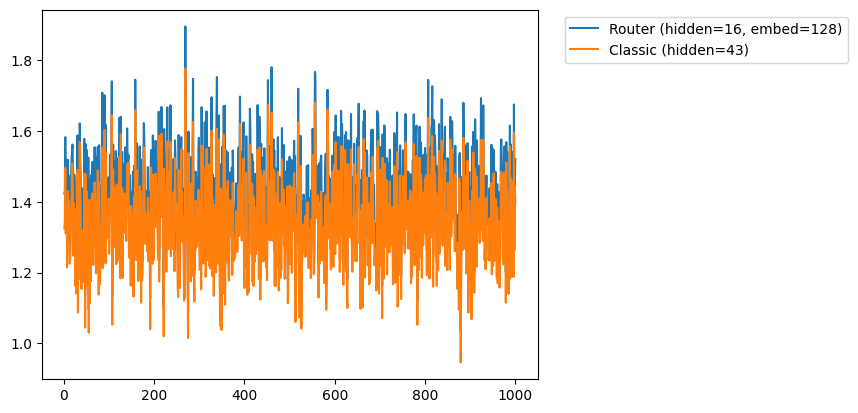

In [ ]:
# --- config ---
n_low = 4
n_high = 5
m = 4
plot_dict = {n: [] for n in range(n_low, n_high)}
classic_plot_dict = {n: [] for n in range(n_low, n_high)}
model_dict = {}
d = 1
w = 2**m
default_embed_dim = 128

layer_sizes = [[3*28*28, w]]
for _ in range(d):
    layer_sizes.append([w, w])
layer_sizes.append([w, 14])

def model_device(model):
    return next(model.parameters()).device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
k_top = 0.5

runs = 1

datasets_per_layer, base_snaps = prepare_router_datasets(
    layer_sizes,
    internal_samples=1000,
    k=k_top,
    device=device,
    contexts_per_task=10,         # many contexts share the same mask
    points_per_context=10,        # IO pairs per context
    dataloader=train_loader,      # <- NEW
)

print("Dataset Constructed")

# infer context size from any per-layer dataset
context_size = datasets_per_layer[0].contexts.shape[1]

# 2) Pretrain autoencoders on masks (decoders frozen)
decoders, _aes = train_autoencoders_for_all_layers(
    datasets_per_layer=datasets_per_layer,
    layer_sizes=layer_sizes,
    embed_dims=default_embed_dim,   # AE embed dim = decoder input dim
    k=k_top,
    epochs=20,
    batch=256,
    lr=1e-3,
    device=device
)

print("Decoders Trained (frozen)")

# 3) Sweep router capacity via hidden width (head size fixed = decoder embed dim)
for n in range(n_low, n_high):
    hidden_width = 2**n
    embed_dim = default_embed_dim  # MUST match decoder input dim

    routers_untrained = [
        build_router_for_layer(context_size, embed_dim=embed_dim, hidden=hidden_width)
        for (_in_f, _out_f) in layer_sizes
    ]

    routers_trained = train_routers_for_all_layers_with_decoders(
                datasets_per_layer=datasets_per_layer,
                routers=routers_untrained,
                decoders=decoders,
                layer_sizes=layer_sizes,
                k=k_top,
                epochs=10,
                batch_size=128,
                lr=1e-3,
                device=device
            )
    if runs > 1:
      print("Trainining Run 1 Complete")
    for run in range(runs-1):

        datasets_per_layer, base_snaps = prepare_router_datasets(
            layer_sizes,
            internal_samples=100,
            k=k_top,
            device=device,
            contexts_per_task=100,         # many contexts share the same mask
            points_per_context=10          # IO pairs per context
        )

        routers_trained = train_routers_for_all_layers_with_decoders(
            datasets_per_layer=datasets_per_layer,
            routers=routers_trained,
            decoders=decoders,
            layer_sizes=layer_sizes,
            k=k_top,
            epochs=10,
            batch_size=128,
            lr=1e-3,
            device=device
        )
        print("Trainining Run "+str(run+2)+" Complete")
    print(f"Routers Trained (hidden={hidden_width}, embed_dim={embed_dim})")


    model_with_router = build_router_inference_model_with_decoders(
        layer_sizes=layer_sizes,
        routers_trained=routers_trained,
        decoders=decoders,
        base_snaps=base_snaps,
        k=k_top,
        device=device
    )
    model_dict[n] = model_with_router

    num_params = sum(param.numel() for param in model_dict[n].parameters() if param.requires_grad)
    # we want num_params to equal the number of learnable paramets in our classic model
    # that is, we want num_params = (c+3*28*28)*w+w+d*w*w+d*w+w*14+14
    # so, solve for w to get w=-(2367 + context_dim + d - math.sqrt(5602689 + context_dim**2 + 4678*d + d**2 + 2*context_dim*(2367 + d) + 4*d*num_params))/(2*d)
    points_per_context=10
    xb0, yb0 = next(iter(train_loader))
    in_dim  = xb0.reshape(xb0.size(0), -1).size(1)                  # flatten X → [N, in_dim]
    out_dim = (_process_Y_to_2d(yb0)).size(1)                       # make Y 2D (one-hot if labels) → [N, out_dim]
    context_dim = points_per_context * (in_dim + out_dim)
    w=max(1,int(-(2367 + context_dim + d - math.sqrt(5602689 + context_dim**2 + 4678*d + d**2 + 2*context_dim*(2367 + d) + 4*d*num_params))/(2*d)))
    # print(w)
    classic_layer_sizes = [[in_dim, w]]
    for _ in range(d):
        classic_layer_sizes.append([w, w])
    classic_layer_sizes.append([w, out_dim])

    classic_model = ClassicNetwork(classic_layer_sizes, expect_context=True, context_dim=context_dim).to(device)
    # print(sum(param.numel() for param in classic_model.parameters() if param.requires_grad)/num_params)
    classic_model.eval()
    model_with_router.eval()

    # Build context bank (CPU)
    context_bank_X = []
    context_bank_Y = []
    with torch.no_grad():
        for xb, yb in train_loader:
            context_bank_X.append(xb.detach().cpu())
            context_bank_Y.append(yb.detach().cpu())
            if sum(x.shape[0] for x in context_bank_X) >= 5000:
                break
    X_bank = torch.cat(context_bank_X, dim=0)  # [N, ...]
    Y_bank = torch.cat(context_bank_Y, dim=0)  # [N] or [N, ...]
    num_classes = int(Y_bank.max().item()) + 1 if (Y_bank.dim() == 1 and Y_bank.dtype in (torch.int32, torch.int64)) else None

    # ---- 2) Evaluate over some batches (can be the same train_loader or a val/test loader) ----
    ys_router, xs = [], []
    ys_classic = []
    max_eval_batches = 1000   # how many batches to score for the curve
    points_per_context = 10  # how many (x,y) pairs to include in each context row

    with torch.no_grad():
        bcount = 0
        for x_eval, y_eval in train_loader:  # replace with val_loader if you have one
            x_eval = x_eval.to(device)
            y_eval = y_eval.to(device)

            # Build a [1, C] context row on-the-fly from the bank and evaluate
            loss = testlosses(
                model_with_router, x_eval, y_eval,
                context=None,
                context_from_training=(X_bank, Y_bank),
                points_per_context=points_per_context,
                replace=True,
            )
            loss_classic = testlosses(
                classic_model, x_eval, y_eval,
                context=None,
                context_from_training=(X_bank, Y_bank),
                points_per_context=points_per_context,
                replace=True,
            )
            ys_classic.append(loss_classic)
            ys_router.append(loss)
            xs.append(len(xs) + 1)

            bcount += 1
            if bcount >= max_eval_batches:
                break

    plot_dict[n] = (xs, ys_router)
    classic_plot_dict[n] = (xs, ys_classic)

# plot
for n in range(n_low, n_high):
    plt.plot(plot_dict[n][0], plot_dict[n][1], label=f"Router (hidden={2**n}, embed={default_embed_dim})")
    plt.plot(classic_plot_dict[n][0], classic_plot_dict[n][1], label=f"Classic (hidden={w})")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")